In [1]:
# Import libraries 
from laspy.file import File
from scipy import spatial
import whitebox
import osgeo.ogr as ogr
import osgeo.osr as osr
import rasterio as rio
import open3d as o3d

from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
# Point cloud denosing.
def denoising(input_dir,n,k):
    working_dir, filename = os.path.split(input_dir)
    # Read the point cloud
    inFile = File(input_dir, mode='r')
    points = inFile.points
    x,y,z = inFile.x,inFile.y,inFile.z
    
    # Packaging x,y,z
    lasdata = zip(x,y,z)
    tree = spatial.cKDTree(list(lasdata))
    # Conditional parameter
    sigma=n # Recommend:10
    K=k # Recommend:50
    k_dist=np.zeros_like(x)
    for i in range(len(x)):
        dist,index =tree.query(np.array([x[i],y[i],z[i]]), K)
        k_dist[i] = np.sum(dist)
    # The max distance of noise points
    max_distance = np.mean(k_dist) + sigma*np.std(k_dist)
    # The index
    outer_index=np.where(k_dist>max_distance)
    inner_index=np.where(k_dist<max_distance)
    print('outer points index array is:', outer_index)
    
    # Save points
    denoised_dir = os.path.join(working_dir, "denoising.las")
    outFile = File(denoised_dir,mode='w', header=inFile.header)
    outFile.points = points[inner_index]
    outFile.close()
    
    return(denoised_dir)

In [3]:
# Point cloud filtering.
# radius:The radius is bigger,and the resolution is better;
# but the time is much longger.
def filtering(denoised_dir, radius):
    working_dir, filename = os.path.split(denoised_dir)
    filtered_dir = os.path.join(working_dir, 'filter.las')
    
    wbt = whitebox.WhiteboxTools()
    wbt.set_verbose_mode(False) # Sets verbose mode. If verbose mode is False, tools will not print output messages
    
    inFile = File(denoised_dir, mode = "r")
    cls = inFile.classification
    if (cls[np.where(cls==2)].shape[0] > 0):
        wbt.height_above_ground(
        i=denoised_dir, 
        output=filtered_dir)
    else:
        wbt.lidar_ground_point_filter(
            i=denoised_dir, 
            output=filtered_dir, 
            radius=radius, 
            min_neighbours=0, 
            slope_threshold=45.0, 
            height_threshold=0.01, 
            classify=True, 
            slope_norm=True, 
            height_above_ground=True)
    
    return(filtered_dir)

In [4]:
# CHM generation
def CHM(filtered_dir,resolution):
    working_dir, filename = os.path.split(filtered_dir)
    CHM_dir = os.path.join(working_dir, 'CHM.tif')
    wbt = whitebox.WhiteboxTools()
    wbt.set_verbose_mode(False)
    #Generating CHM and save it.
    wbt.lidar_tin_gridding(
        i=filtered_dir,
        output=CHM_dir,
        parameter="elevation",
        returns="all",
        resolution=resolution, 
        exclude_cls=None, 
        minz=None,
        maxz=None,
        max_triangle_edge_length=None)
    
    return(CHM_dir)

In [5]:
def Write_to_pcd(path):
    inFile = File(path, mode='r')
    x,y,z = inFile.x,inFile.y,inFile.z
    # Remove offset.
    x_offset = x - np.min(x)
    y_offset = y - np.min(y)
    z_offset = z - np.min(z)
    points = zip(x_offset,y_offset,z_offset)
    # Write to pcd.
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    return(pcd)

In [6]:
# Point Cloud Visualization.
def custom_draw_geometry_with_key_callback(pcd):
    # Create a path to save a screen capture.
    root_dir = os.path.join(os.path.expanduser("~"), 'Desktop')
    save_path = os.path.join(root_dir, 'Screenshot.png')
    # Change the background.
    def change_background_to_black(vis):
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])
        return False

    def capture_depth(vis):
        depth = vis.capture_depth_float_buffer()
        plt.imshow(np.asarray(depth))
        plt.show()
        return False
    # Save image.
    def capture_image(vis):
        image = vis.capture_screen_float_buffer()
        fig,ax = plt.subplots(figsize=(20,20))
        ax.imshow(image)
        plt.savefig(save_path)
        return False

    key_to_callback = {}
    key_to_callback[ord("K")] = change_background_to_black
    key_to_callback[ord(",")] = capture_depth
    key_to_callback[ord(".")] = capture_image
    o3d.visualization.draw_geometries_with_key_callbacks([pcd], key_to_callback)

In [7]:
def CHM_Visualization(path):
    img = io.imread(path)
    img = np.array(img*255,dtype='uint8')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(img, cmap=plt.cm.gray)
    axes[0].set_title('img')
    axes[1].imshow(img, cmap=plt.cm.jet)
    axes[1].set_title('img(jet)')
    
#     fig,ax = plt.subplots(figsize=(10,10))
#     ax.imshow(img, cmap=plt.cm.gray)

In [8]:
# Step 1: Point Cloud Denosing
input_dir = r"C:\Users\Pix4D-WS\Desktop\test\test.las"
denoised_dir = denoising(input_dir,10,50)
print(denoised_dir)

outer points index array is: (array([   13599,    18383,    30593, ..., 15090549, 15090550, 15090551],
      dtype=int64),)
C:\Users\Pix4D-WS\Desktop\test\denoising.las


In [9]:
# Step 2: Point Cloud Filtering.
filtered_dir = filtering(denoised_dir, 2.0)
print(filtered_dir)

C:\Users\Pix4D-WS\Desktop\test\filter.las


In [10]:
# Step 3: Canopy Height Model.
CHM_dir = CHM(filtered_dir,0.01)
print(CHM_dir)

C:\Users\Pix4D-WS\Desktop\test\CHM.tif


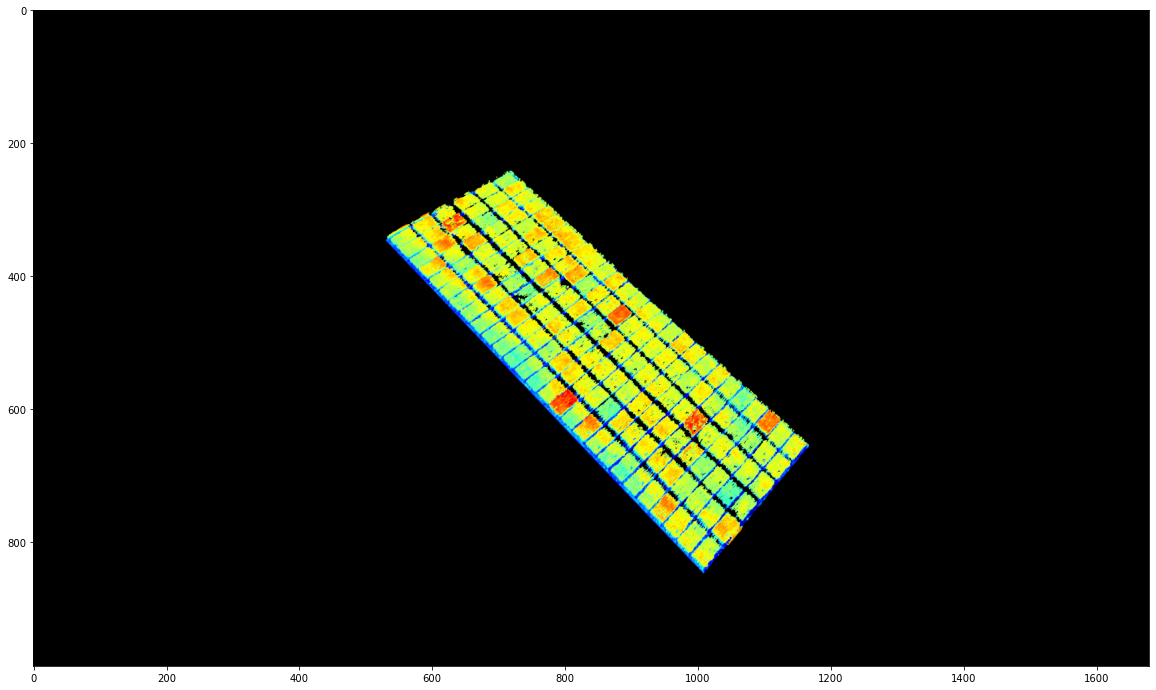

In [11]:
# Visualization: Step 1.
Denoised_pcd = Write_to_pcd(denoised_dir)

custom_draw_geometry_with_key_callback(Denoised_pcd)

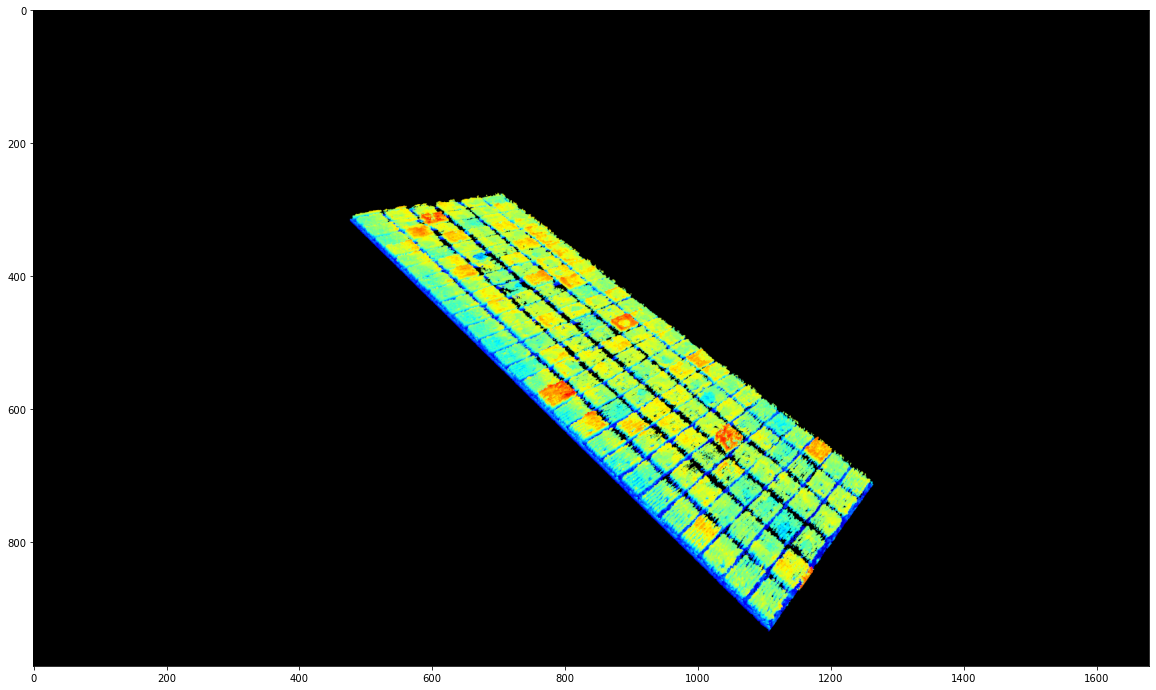

In [12]:
# Visualization: Step 2.
Filtered_pcd = Write_to_pcd(filtered_dir)

custom_draw_geometry_with_key_callback(Filtered_pcd)

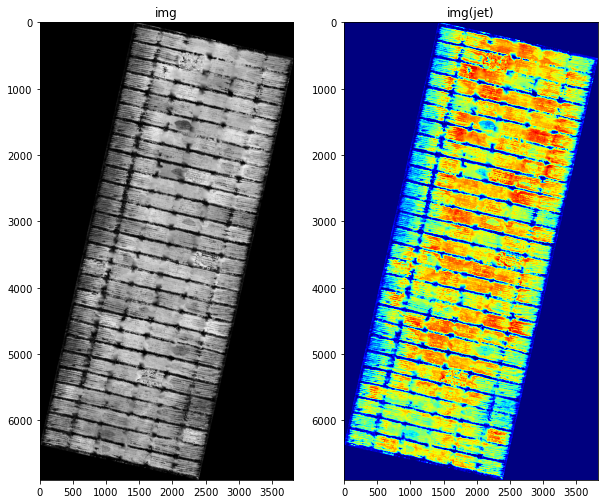

In [13]:
# Visualization: Step 3.
CHM_Visualization(CHM_dir)